✅ Saved trend file with CI-based trend classifications.


/tmp/ipykernel_13402/677572162.py:123: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(wards))


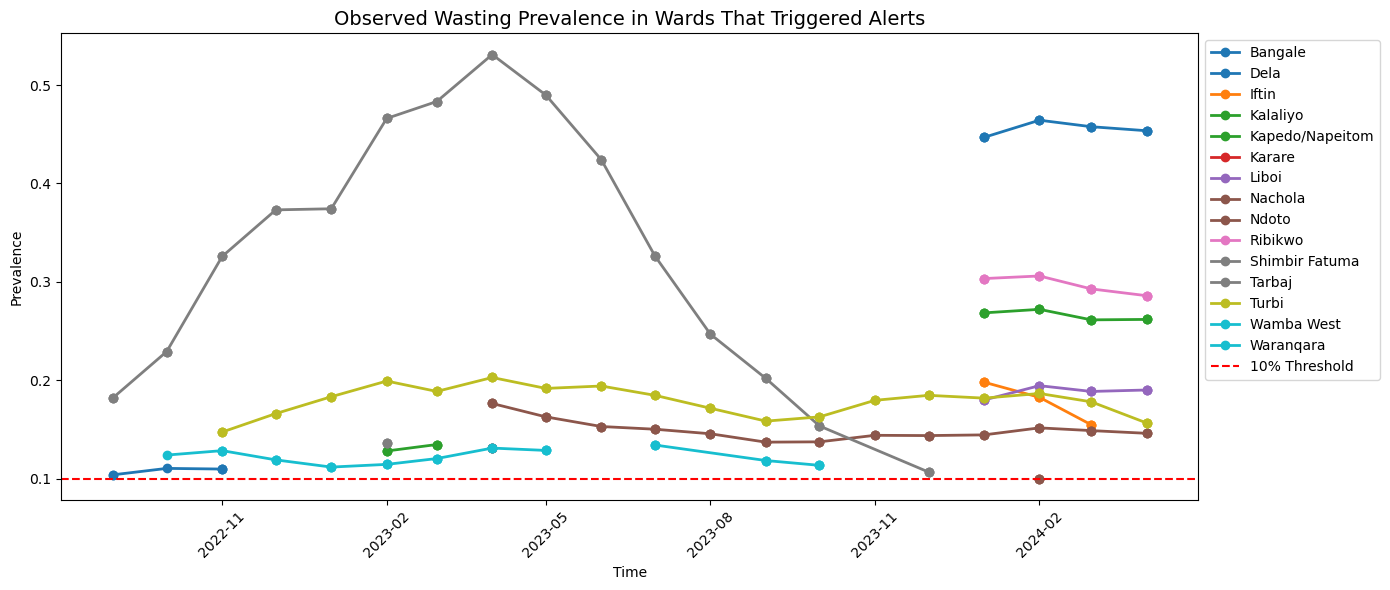

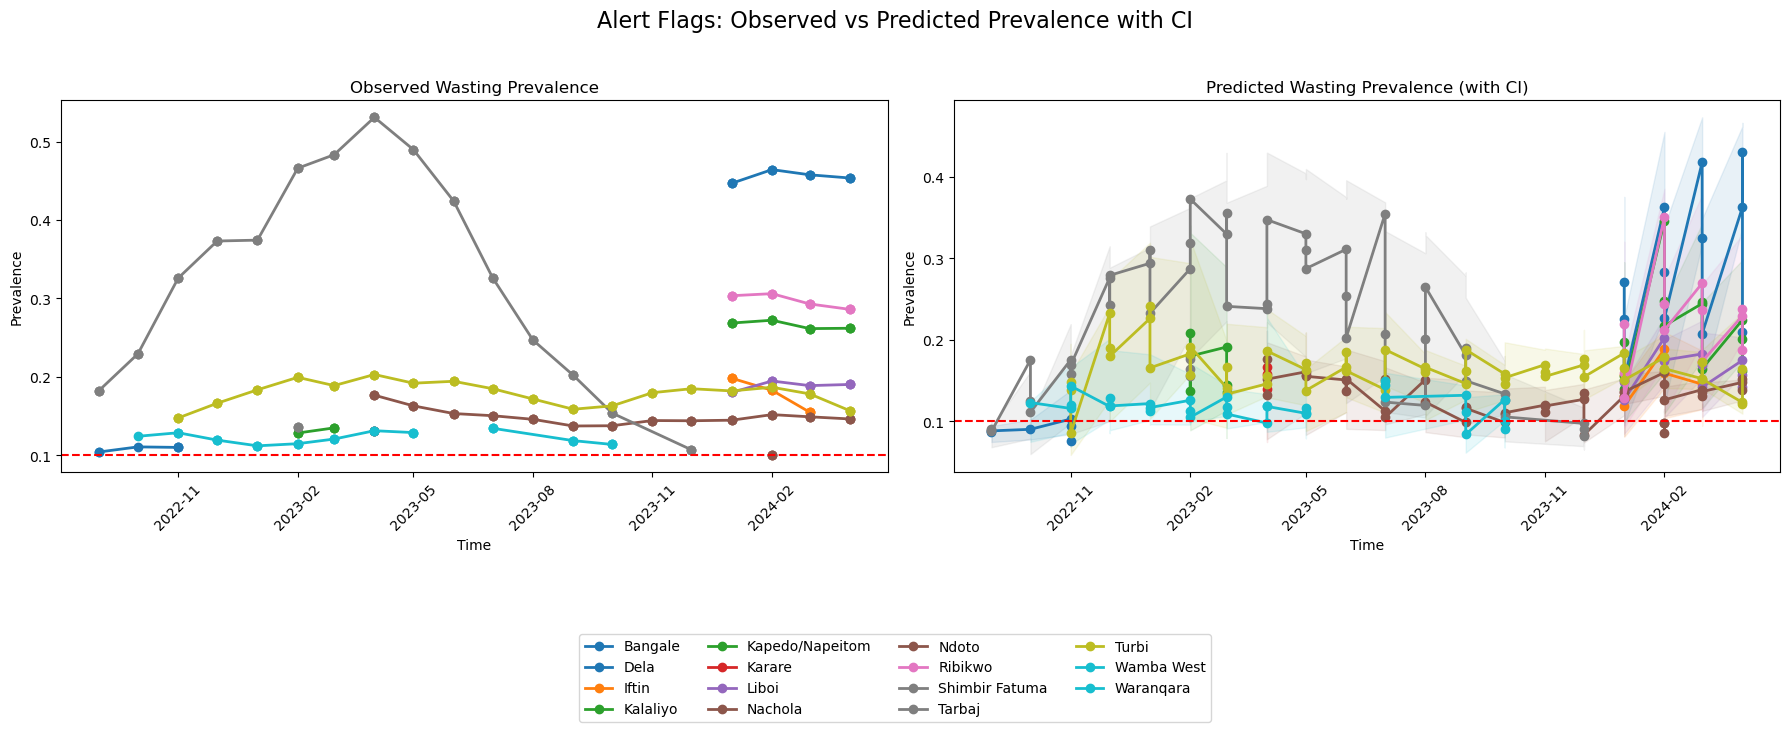

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
# === Classifiers ===

def classify(delta):
    if pd.isna(delta):
        return "No Data"
    elif delta > 0.01:
        return "Increasing"
    elif delta < -0.01:
        return "Decreasing"
    else:
        return "Stable"

def classify_with_ci(observed, lower, upper):
    if pd.isna(observed) or pd.isna(lower) or pd.isna(upper):
        return "No Data"
    if lower > observed + 0.01:
        return "Increasing"
    elif upper < observed - 0.01:
        return "Decreasing"
    else:
        return "Stable"

# === Load data ===
hb_1 = pd.read_csv("data/Smoothed_wasting_prediction_hb_1.csv")
hb_2 = pd.read_csv("data/Smoothed_wasting_prediction_hb_2.csv")
hb_3 = pd.read_csv("data/Smoothed_wasting_prediction_hb_3.csv")

for df in [hb_1, hb_2, hb_3]:
    df["time_period"] = pd.to_datetime(df["time_period"])
    df["Ward"] = df["Ward"].str.strip()

obs = hb_1[["Ward", "County", "time_period", "observed"]].copy()

def shift_predictions(df, months_back, horizon):
    return df.assign(
        time_period=df["time_period"] - pd.DateOffset(months=months_back)
    )[["Ward", "time_period", f"pred_{horizon}", f"lower_bound_{horizon}", f"upper_bound_{horizon}"]]

pred_1mo = shift_predictions(hb_1, 1, "1mo")
pred_2mo = shift_predictions(hb_2, 2, "2mo")
pred_3mo = shift_predictions(hb_3, 3, "3mo")

merged = obs.merge(pred_1mo, on=["Ward", "time_period"], how="left") \
            .merge(pred_2mo, on=["Ward", "time_period"], how="left") \
            .merge(pred_3mo, on=["Ward", "time_period"], how="left")

merged.dropna(subset=["observed", "pred_1mo", "pred_2mo", "pred_3mo"], inplace=True)
merged.sort_values(by=["Ward", "time_period"], inplace=True)

# Standard trends
merged["trend_1mo"] = (merged["pred_1mo"] - merged["observed"]).apply(classify)
merged["trend_2mo"] = (merged["pred_2mo"] - merged["observed"]).apply(classify)
merged["trend_3mo"] = (merged["pred_3mo"] - merged["observed"]).apply(classify)

# CI-based trends
merged["trend_with_CI_1mo"] = merged.apply(
    lambda row: classify_with_ci(row["observed"], row["lower_bound_1mo"], row["upper_bound_1mo"]), axis=1)
merged["trend_with_CI_2mo"] = merged.apply(
    lambda row: classify_with_ci(row["observed"], row["lower_bound_2mo"], row["upper_bound_2mo"]), axis=1)
merged["trend_with_CI_3mo"] = merged.apply(
    lambda row: classify_with_ci(row["observed"], row["lower_bound_3mo"], row["upper_bound_3mo"]), axis=1)

# Observed trends
merged["observed_slope_2mo"] = merged.groupby("Ward")["observed"].transform(
    lambda x: x.rolling(window=2, min_periods=2).apply(lambda y: pd.Series(y).diff().mean()))
merged["observed_trend_2mo"] = merged["observed_slope_2mo"].apply(classify)

# Build long format
def build_trend_long(horizon_label):
    return merged[["Ward", "time_period", 
                   f"trend_{horizon_label}",
                   f"trend_with_CI_{horizon_label}", 
                   f"pred_{horizon_label}",
                   f"lower_bound_{horizon_label}", 
                   f"upper_bound_{horizon_label}"]].rename(
        columns={
            f"trend_{horizon_label}": "predicted_trend",
            f"pred_{horizon_label}": "predicted_value",
            f"lower_bound_{horizon_label}": "lower_bound",
            f"upper_bound_{horizon_label}": "upper_bound",
            f"trend_with_CI_{horizon_label}": "predicted_trend_CI"

        }
    ).assign(horizon=horizon_label)

trend_long = pd.concat([
    build_trend_long("1mo"),
    build_trend_long("2mo"),
    build_trend_long("3mo")
], ignore_index=True)

# Add observed values
obs_trend_cols = ["Ward","County", "time_period", "observed", 
                  "observed_trend_2mo"]
trend_long = trend_long.merge(merged[obs_trend_cols], on=["Ward", "time_period"], how="left")

# Alert condition (CI-based trend is increasing + observed trend is increasing + observed >= 0.10)
trend_long["alert_flag"] = (
    (trend_long["observed"] >= 0.10) &
    (trend_long["predicted_trend_CI"].isin(["Increasing", "Stable"])) &
    (trend_long["observed_trend_2mo"].isin(["Increasing", "Stable"]))
) | (trend_long["observed"] >= 0.15)


# Sort for each ward by time
trend_long = trend_long.sort_values(["Ward", "time_period"])

# === Save and plot ===
trend_long.to_csv("data/clean_trend_long_with_CI.csv", index=False)
print("✅ Saved trend file with CI-based trend classifications.")

# === Plot flagged wards ===

# Filter to alerts only
alerts = trend_long[trend_long["alert_flag"] == True]

# Unique wards
wards = alerts["Ward"].unique()
colors = plt.cm.get_cmap("tab10", len(wards))


# Initialize figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each ward
for i, ward in enumerate(wards):
    ward_data = alerts[alerts["Ward"] == ward].sort_values("time_period")
    ax.plot(
        ward_data["time_period"],
        ward_data["observed"],
        label=ward,
        color=colors(i),
        marker="o",
        linewidth=2
    )

# Reference line
ax.axhline(0.10, linestyle="--", color="red", linewidth=1.5, label="10% Threshold")

# Format x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', rotation=45)

# Titles and labels
ax.set_title("Observed Wasting Prevalence in Wards That Triggered Alerts", fontsize=14)
ax.set_ylabel("Prevalence")
ax.set_xlabel("Time")

# Add legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Layout
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharex=True)
obs_ax, pred_ax = axs

# Store line handles and labels for legend
legend_handles = []

for i, ward in enumerate(wards):
    ward_data = alerts[alerts["Ward"] == ward].sort_values("time_period")

    # === Observed ===
    obs_line, = obs_ax.plot(
        ward_data["time_period"],
        ward_data["observed"],
        color=colors(i),
        marker="o",
        linewidth=2
    )

    # === Predicted with CI ===
    pred_ax.plot(
        ward_data["time_period"],
        ward_data["predicted_value"],
        color=colors(i),
        marker="o",
        linewidth=2
    )
    pred_ax.fill_between(
        ward_data["time_period"],
        ward_data["lower_bound"],
        ward_data["upper_bound"],
        color=colors(i),
        alpha=0.1
    )

    # Collect for legend (once per ward)
    legend_handles.append((obs_line, ward))

# Format x-axis
for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)
    ax.axhline(0.10, linestyle="--", color="red", linewidth=1.5)

# Titles and labels
obs_ax.set_title("Observed Wasting Prevalence")
obs_ax.set_ylabel("Prevalence")
obs_ax.set_xlabel("Time")

pred_ax.set_title("Predicted Wasting Prevalence (with CI)")
pred_ax.set_ylabel("Prevalence")
pred_ax.set_xlabel("Time")

# Add shared legend
fig.legend(
    [h for h, _ in legend_handles],
    [label for _, label in legend_handles],
    loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4
)

fig.suptitle("Alert Flags: Observed vs Predicted Prevalence with CI", fontsize=16)
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


# === Pivot data wide ===
trend_long = (
    trend_long.sort_values(["Ward", "time_period", "horizon"])
    .drop_duplicates(subset=["Ward", "time_period", "horizon"], keep="first")
)

# Pivot predicted values
pred_values = trend_long.pivot(index=["Ward", "time_period"], columns="horizon", values="predicted_value")
pred_values.columns = [f"predicted_value_{col}" for col in pred_values.columns]

# Pivot predicted trends
pred_trends = trend_long.pivot(index=["Ward", "time_period"], columns="horizon", values="predicted_trend")
pred_trends.columns = [f"predicted_trend_{col}" for col in pred_trends.columns]

# Pivot CI-based trends
pred_trends_ci = trend_long.pivot(index=["Ward", "time_period"], columns="horizon", values="predicted_trend_CI")
pred_trends_ci.columns = [f"predicted_trend_CI_{col}" for col in pred_trends_ci.columns]

# Pivot lower and upper bounds
lower_bounds = trend_long.pivot(index=["Ward", "time_period"], columns="horizon", values="lower_bound")
lower_bounds.columns = [f"lower_bound_{col}" for col in lower_bounds.columns]

upper_bounds = trend_long.pivot(index=["Ward", "time_period"], columns="horizon", values="upper_bound")
upper_bounds.columns = [f"upper_bound_{col}" for col in upper_bounds.columns]

# Keep only unique observed-related values
observed = (
    trend_long[["Ward", "County", "time_period", "observed", 
                "observed_trend_2mo", "alert_flag"]]
    .drop_duplicates(subset=["Ward", "time_period"])
    .set_index(["Ward", "time_period"])
)

# Merge all together
trend_wide = pd.concat([
    observed, 
    pred_values, 
    pred_trends, 
    pred_trends_ci,
    lower_bounds,
    upper_bounds
], axis=1).reset_index()

# Compute consecutive alert streaks
trend_wide = trend_wide.sort_values(by=["Ward", "time_period"])

trend_wide["consecutive_alerts"] = 0
for ward, group in trend_wide.groupby("Ward"):
    streak = (group["alert_flag"]
              .astype(int)
              .groupby((~group["alert_flag"]).cumsum())
              .cumsum())
    trend_wide.loc[group.index, "consecutive_alerts"] = streak.values

trend_wide.to_csv("data/clean_trend_wide_with_CI.csv", index=False)


# compress_figures.py
from PIL import Image
from pathlib import Path

src = Path("assets/figures")   # put your images here
src.mkdir(parents=True, exist_ok=True)

for p in list(src.glob("*.png")) + list(src.glob("*.jpg")) + list(src.glob("*.jpeg")):
    out = p.with_suffix(".webp")
    if out.exists() and out.stat().st_mtime >= p.stat().st_mtime:
        continue
    img = Image.open(p).convert("RGB")
    w, h = img.size
    max_w = 1200
    if w > max_w:
        h = int(h * max_w / w)
        img = img.resize((max_w, h), Image.LANCZOS)
    img.save(out, "WEBP", quality=80, method=6)
    print("✓", out.name)

In [3]:
trend_long

,Ward,time_period,predicted_trend,predicted_trend_CI,predicted_value,lower_bound,upper_bound,horizon,County,observed,observed_trend_2mo,alert_flag
0,Abakaile,2024-01-01,Stable,Stable,0.000000,-0.000947,0.001695,1mo,Garissa,0.0,No Data,False
21817,Abakaile,2024-01-01,Stable,Stable,0.000517,-0.002443,0.003773,2mo,Garissa,0.0,No Data,False
43634,Abakaile,2024-01-01,Stable,Stable,0.002049,-0.003626,0.004574,3mo,Garissa,0.0,No Data,False
1,Abakaile,2024-02-01,Stable,Stable,0.000483,-0.003928,0.002060,1mo,Garissa,0.0,Stable,False
21818,Abakaile,2024-02-01,Stable,Stable,0.000000,-0.007996,0.006945,2mo,Garissa,0.0,Stable,False
...,...,...,...,...,...,...,...,...,...,...,...,...
43632,Witu,2024-03-01,Stable,Stable,0.003561,-0.002440,0.010719,2mo,Lamu,0.0,Stable,False
65449,Witu,2024-03-01,Stable,Stable,0.000172,-0.003508,0.001384,3mo,Lamu,0.0,Stable,False
21816,Witu,2024-04-01,Stable,Stable,0.000000,-0.001151,0.000312,1mo,Lamu,0.0,Stable,False
43633,Witu,2024-04-01,Stable,Stable,0.000000,-0.002161,0.000996,2mo,Lamu,0.0,Stable,False
